In [1]:
!pip install rdkit

In [28]:
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import os 
import sys

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)

import os_navigation as os_nav

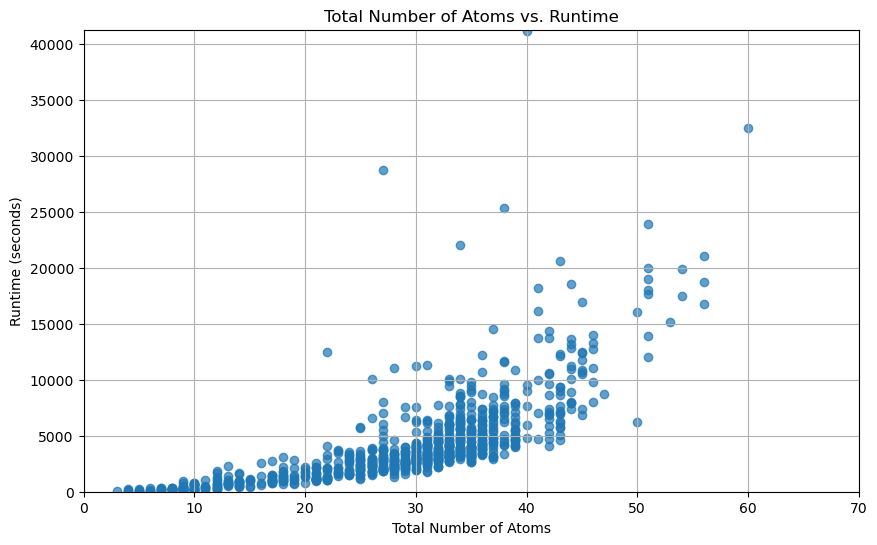

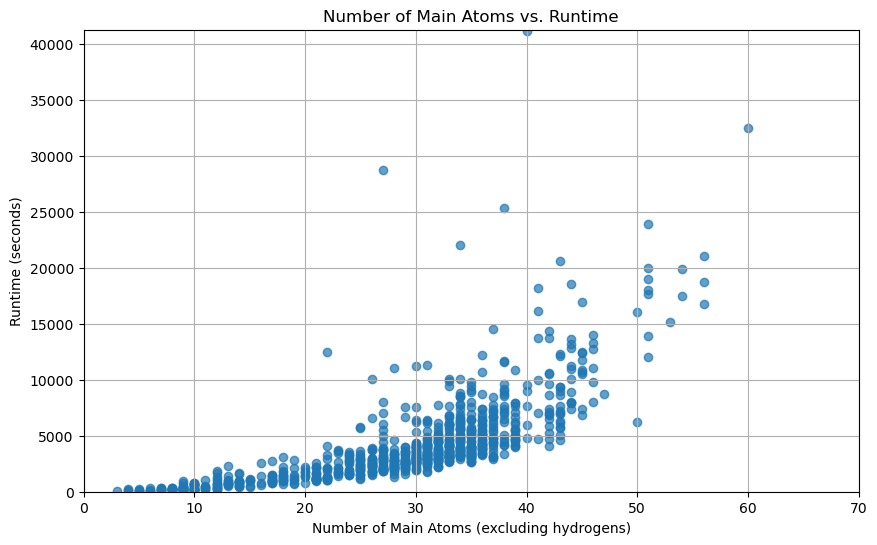

In [37]:
# Paths to CSV files
path_to_job_csv = os.path.join(os_nav.find_project_root(), 'data', 'jobs', 'all_jaguar_jobs.csv')
path_to_molecule_csv = os.path.join(os_nav.find_project_root(), 'data', 'mols', 'wittig_molecules.csv')

# Load the job data
job_data = pd.read_csv(path_to_job_csv)

# Filter jobs that are 'FINISHED'
finished_jobs = job_data[job_data['job_status'] == 'FINISHED'].copy()

# Extract the second component of the 'job_id' as a separate column
finished_jobs.loc[:, 'molecule_code'] = finished_jobs['job_id'].apply(lambda x: x.split('_')[1])

# Load the molecule data
molecule_data = pd.read_csv(path_to_molecule_csv)

# Create a dictionary to map molecule codes to SMILES strings
code_to_smiles = {}
for idx, row in molecule_data.iterrows():
    code_to_smiles[str(idx)] = row['smiles']

# Calculate the number of atoms for each molecule and add it to the job_data dataframe
n_atoms_list = []
n_main_atoms_list = []

for code in finished_jobs['molecule_code']:
    smiles = code_to_smiles.get(code)
    if smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            n_atoms = mol.GetNumAtoms()
            n_main_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() > 1)
            n_atoms_list.append(n_atoms)
            n_main_atoms_list.append(n_main_atoms)
        else:
            n_atoms_list.append(None)
            n_main_atoms_list.append(None)
    else:
        n_atoms_list.append(None)
        n_main_atoms_list.append(None)

finished_jobs.loc[:, 'n_atoms'] = n_atoms_list
finished_jobs.loc[:, 'n_main_atoms'] = n_main_atoms_list

# Convert runtime to seconds for plotting
def time_to_seconds(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

finished_jobs.loc[:, 'runtime_seconds'] = finished_jobs['runtime'].apply(time_to_seconds)

# Drop rows with None values
finished_jobs = finished_jobs.dropna(subset=['n_atoms', 'n_main_atoms', 'runtime_seconds'])

# Plotting total number of atoms vs. runtime
plt.figure(figsize=(10, 6))
plt.scatter(finished_jobs['n_atoms'], finished_jobs['runtime_seconds'], alpha=0.7)
plt.title('Total Number of Atoms vs. Runtime')
plt.xlabel('Total Number of Atoms')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.xlim(0, finished_jobs['n_atoms'].max() + 10)  # Set x-axis limits to a reasonable range for number of atoms
plt.ylim(0, finished_jobs['runtime_seconds'].max() + 100)  # Set y-axis limits to include all runtimes
plt.show()

# Plotting number of main atoms vs. runtime
plt.figure(figsize=(10, 6))
plt.scatter(finished_jobs['n_main_atoms'], finished_jobs['runtime_seconds'], alpha=0.7)
plt.title('Number of Main Atoms vs. Runtime')
plt.xlabel('Number of Main Atoms (excluding hydrogens)')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.xlim(0, finished_jobs['n_main_atoms'].max() + 10)  # Set x-axis limits to a reasonable range for number of main atoms
plt.ylim(0, finished_jobs['runtime_seconds'].max() + 100)  # Set y-axis limits to include all runtimes
plt.show()

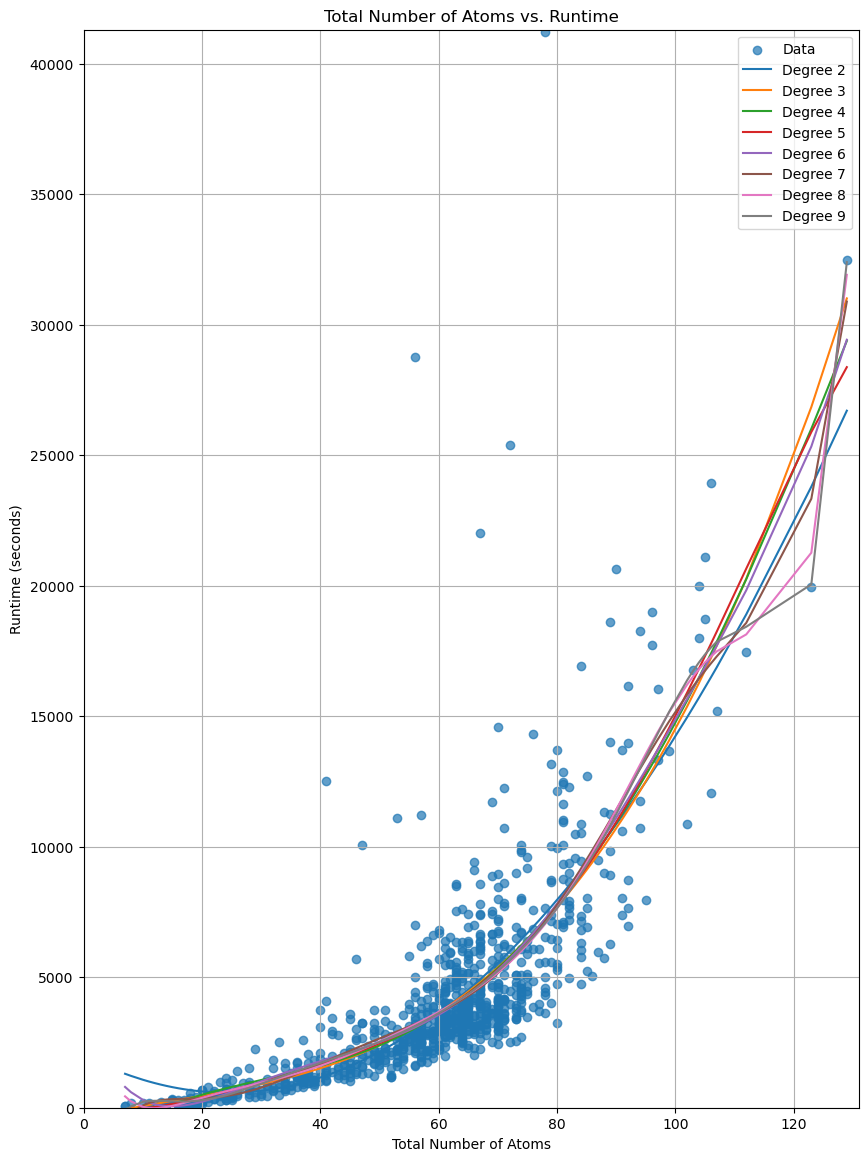

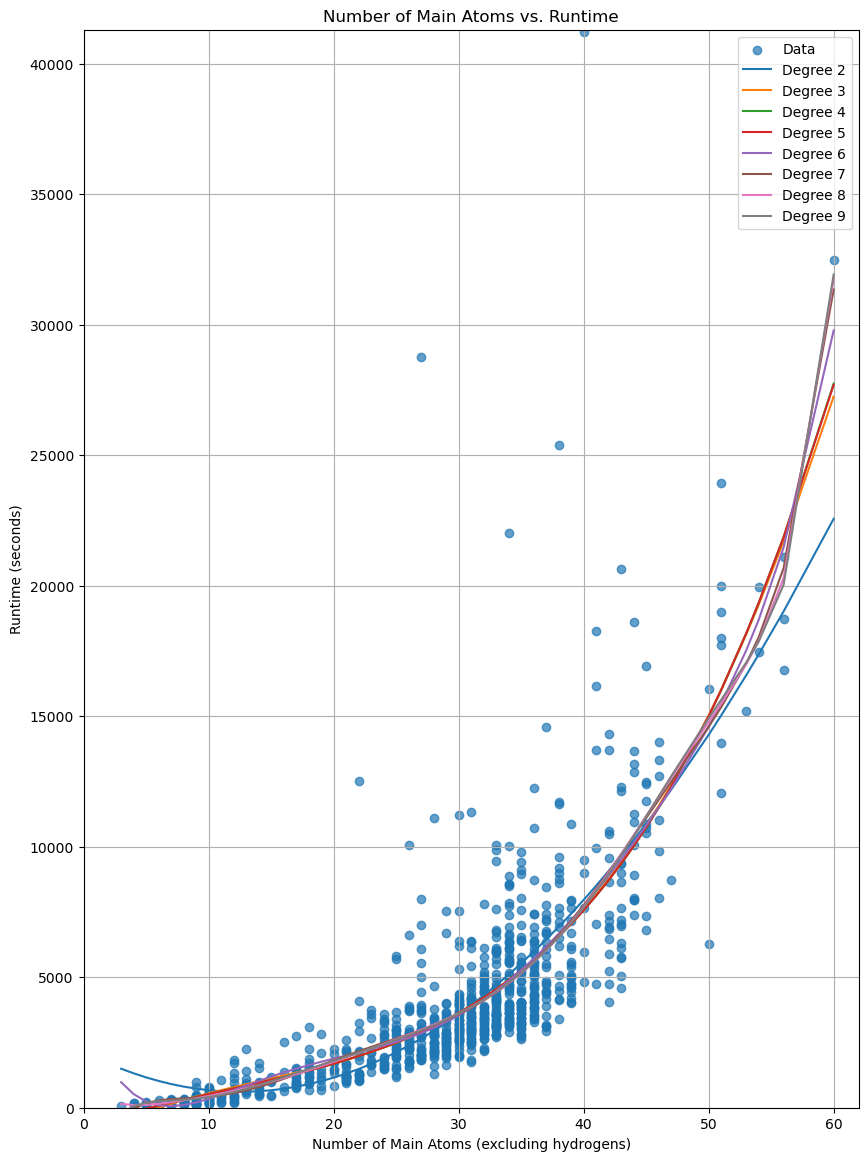

In [42]:
# Load the job data
job_data = pd.read_csv(path_to_job_csv)

# Filter jobs that are 'FINISHED'
finished_jobs = job_data[job_data['job_status'] == 'FINISHED'].copy()

# Extract the second component of the 'job_id' as a separate column
finished_jobs.loc[:, 'molecule_code'] = finished_jobs['job_id'].apply(lambda x: x.split('_')[1])

# Load the molecule data
molecule_data = pd.read_csv(path_to_molecule_csv)

# Create a dictionary to map molecule codes to SMILES strings
code_to_smiles = {}
for idx, row in molecule_data.iterrows():
    code_to_smiles[str(idx)] = row['smiles']

# Calculate the number of atoms for each molecule and add it to the job_data dataframe
n_atoms_list = []
n_main_atoms_list = []

for code in finished_jobs['molecule_code']:
    smiles = code_to_smiles.get(code)
    if smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol = Chem.AddHs(mol)
            n_atoms = mol.GetNumAtoms()
            n_main_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() > 1)
            n_atoms_list.append(n_atoms)
            n_main_atoms_list.append(n_main_atoms)
        else:
            n_atoms_list.append(None)
            n_main_atoms_list.append(None)
    else:
        n_atoms_list.append(None)
        n_main_atoms_list.append(None)

finished_jobs.loc[:, 'n_atoms'] = n_atoms_list
finished_jobs.loc[:, 'n_main_atoms'] = n_main_atoms_list

# Convert runtime to seconds for plotting
def time_to_seconds(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

finished_jobs.loc[:, 'runtime_seconds'] = finished_jobs['runtime'].apply(time_to_seconds)

# Drop rows with None values
finished_jobs = finished_jobs.dropna(subset=['n_atoms', 'n_main_atoms', 'runtime_seconds'])

# Polynomial fitting function
def fit_polynomial(x, y, degree):
    p = np.polyfit(x, y, degree)
    return np.poly1d(p)

# Fit polynomial models for degrees 2 through 9
degrees = range(2, 10)

# Total atoms vs. runtime
x_total_atoms = finished_jobs['n_atoms']
y_runtime = finished_jobs['runtime_seconds']

# Plotting total number of atoms vs. runtime with polynomial fits
plt.figure(figsize=(10, 14))
plt.scatter(x_total_atoms, y_runtime, alpha=0.7, label='Data')

for degree in degrees:
    poly_total_atoms = fit_polynomial(x_total_atoms, y_runtime, degree)
    plt.plot(np.sort(x_total_atoms), poly_total_atoms(np.sort(x_total_atoms)), label=f'Degree {degree}')

plt.title('Total Number of Atoms vs. Runtime')
plt.xlabel('Total Number of Atoms')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.xlim(0, finished_jobs['n_atoms'].max() + 2)
plt.ylim(0, finished_jobs['runtime_seconds'].max() + 100)
plt.show()

# Main atoms vs. runtime
x_main_atoms = finished_jobs['n_main_atoms']

# Plotting number of main atoms vs. runtime with polynomial fits
plt.figure(figsize=(10, 14))
plt.scatter(x_main_atoms, y_runtime, alpha=0.7, label='Data')

for degree in degrees:
    poly_main_atoms = fit_polynomial(x_main_atoms, y_runtime, degree)
    plt.plot(np.sort(x_main_atoms), poly_main_atoms(np.sort(x_main_atoms)), label=f'Degree {degree}')

plt.title('Number of Main Atoms vs. Runtime')
plt.xlabel('Number of Main Atoms (excluding hydrogens)')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.xlim(0, finished_jobs['n_main_atoms'].max() + 2)
plt.ylim(0, finished_jobs['runtime_seconds'].max() + 100)
plt.show()

In [43]:
# Polynomial fitting function for a specific degree
def fit_and_return_polynomial(x, y, degree):
    p = np.polyfit(x, y, degree)
    poly_func = np.poly1d(p)
    return p, poly_func

# Fit the degree 7 polynomial for total atoms vs. runtime
degree = 7
coefficients_total_atoms, poly_total_atoms_func = fit_and_return_polynomial(x_total_atoms, y_runtime, degree)

# Fit the degree 7 polynomial for main atoms vs. runtime
coefficients_main_atoms, poly_main_atoms_func = fit_and_return_polynomial(x_main_atoms, y_runtime, degree)

# Print the coefficients for the degree 7 polynomial for total atoms vs. runtime
print(f"Coefficients for the degree {degree} polynomial (total atoms):")
print(coefficients_total_atoms)

# Print the coefficients for the degree 7 polynomial for main atoms vs. runtime
print(f"Coefficients for the degree {degree} polynomial (main atoms):")
print(coefficients_main_atoms)

# Create lambda functions to evaluate the polynomial at a given number
evaluate_poly_total_atoms = lambda x: poly_total_atoms_func(x)
evaluate_poly_main_atoms = lambda x: poly_main_atoms_func(x)

# Example usage of the lambda functions
x_value = 10
print(f"Polynomial (total atoms) evaluated at {x_value}: {evaluate_poly_total_atoms(x_value)}")
print(f"Polynomial (main atoms) evaluated at {x_value}: {evaluate_poly_main_atoms(x_value)}")


Coefficients for the degree 7 polynomial (total atoms):
[ 1.06482738e-08 -4.61542348e-06  7.92766672e-04 -6.89593731e-02
  3.23848009e+00 -7.96960678e+01  9.67486090e+02 -4.24036733e+03]
Coefficients for the degree 7 polynomial (main atoms):
[ 1.65699635e-06 -3.34081931e-04  2.68124123e-02 -1.09203001e+00
  2.40066130e+01 -2.76086348e+02  1.58053869e+03 -3.22539042e+03]
Polynomial (total atoms) evaluated at 10: 88.54087577919927
Polynomial (main atoms) evaluated at 10: 421.40387229171665
